# Frame  Classification

A common use case is to recognize a single characteristic over an utterance, e.g. who is the speaker or is the speaker male or female (assuming you have a single speaker in the utterance).

If we can do a rough estimate on a frame by frame basis , then we can integrate all that information over all frames.
A simple method exists in treating all frame estimates as independent observations (iid assumption).  The iid. assumption is 
obviously incorrect in this case as the correlation over successive frames for speaker-id is very high.
All things considered such naive method works well for classification. However, you should not believe the posterior probabilities, only the ordering in case of multiple classes.

### CASE STUDY: Recognizing gender 
- atrribute: gender \[m-f\]
- features: standard MFCC feature vectors
- observations: a single utterance of a few secs
- methodology:  
    - training frame based classifiers using GMM's
    - compute the utterance log-likelihood = sum of frame log-likelihood  (is correct under the assumption of iid frames)
    - convert utterance log-likelihood to utterance posteriors (in the demo below we neglect priors, which is most often a valid choice)   
    
Similar scenarios can be developed for applications such as language, dialect, age, ... 





### 1. Setting up 

In [1]:
####################################################################################
### RUNNING THIS CELL FIRST ##########
### will suppresses warnings on memory leaks, deprecation warnings and future warnings 
### It is brute force .  
### Best is not to run it when you want to debug code or new installations
import os, warnings 
os.environ["OMP_NUM_THREADS"] = '2'  
warnings.filterwarnings("ignore")
####################################################################################

In [2]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [3]:
# Importing Python's baseline machine learning stack 
#
%matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from scipy.special import logsumexp
from IPython.display import display,Audio

# imports from the scikit-learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics as skmetrics
from sklearn.mixture import GaussianMixture

import pyspch as Spch
import pyspch.display as Spd
import pyspch.sp as Sps
from pyspch.stats import GMM

# 
np.set_printoptions(precision=2)

In [4]:
root = "https://homes.esat.kuleuven.be/~spchlab/data/timit/"
def read_timit_corpus(root = "https://homes.esat.kuleuven.be/~spchlab/data/timit/",
        name = "conf/timit_train.corpus"):
    '''
    reads part of the TIMIT corpus
    '''
    corpus_txt = Spch.read_txt(root+name)
    corpus_list = []
    for f in corpus_txt:
        _,_,spkr,sent = f.split('/')
        corpus_list.append([f,spkr[0],spkr,sent])
    corpus = pd.DataFrame(corpus_list,columns=['filename','gender','spkr','sent-id'])
    return(corpus)

def get_features(root="https://homes.esat.kuleuven.be/~spchlab/data/timit/",ftrdir="features/mel24/",
                  corpus=None,feature_args=None):
    '''
    gets preprocessed features, optionally postprocessed according to options the feature_extraction() module
    '''
    ftrs = []
    for f in corpus.filename:
        file = root + ftrdir + f + '.npy'
        feature = np.load(Spch.read_fobj(file)) 
        if feature_args:
            feature = Sps.feature_extraction(spg=feature, **feature_args)
        ftrs.append(feature.T)
    return(ftrs)

def make_Xy(corpus=None,ftrs=None,attr='gender',downsample=1):
    '''
    make X,y feature vectors and classes
    from ftrs and attribute 'attr' according to corpus
    '''
    
    fnames = corpus['filename'].to_list()
    X = None
    y = None
    for indx in range(len(corpus)):
        Xi = ftrs[indx][::downsample,:]
        yi = np.array([corpus.iloc[indx][attr]]*Xi.shape[0])
        y = yi if y is None else np.concatenate((y,yi))
        X = Xi if X is None else np.concatenate((X,Xi))
    return X,y

### 2. The Database 
All experiments in this notebook are using (parts of) the TIMIT database

##### TIMIT
The TIMIT database contains well prepared speech recorded in mint acoustic conditions.
The corpus is a mixture of a small set of sentences used by large groups of speakers and sentences that are different for each speaker.

TIMIT is recorded in mint acoustic conditions and uses a sampling rate of 16 kHz.  
Overall there are no long segments of noise/silence at beginning and end of the sentences; thus most of the data in an utterance is indeed speech data. 
For feature vectors we use MFCC-13, followed by (utterance length) mean-normalization.

##### Importing and preprocessing the data
- a. read the corpus files ; i.e. a list of filenames and meta data 
    + we use all speakers in the database but only a subset of the sentences per speaker
    + train and test set are separate and as defined in the database
- b. do feature extraction
    + read precomputed mel filterbanks (24-D) 
    + postprocess with cepstral transformation and mean-norm

**Note:** reading the features may take some  time, depending on the subsize of the corpus you are loading

In [5]:
# get a subset of the timit train corpus
corpus_train = read_timit_corpus(name= "conf/timit_train_si1.corpus")
ftrs_train = get_features(corpus=corpus_train, ftrdir = "features/mel24/", feature_args = {'n_cep':13,'Norm':'mean'} )

In [6]:
# get a subset of the timit test corpus
corpus_test = read_timit_corpus(name= "conf/timit_test_si1.corpus")
ftrs_test = get_features(corpus=corpus_test, ftrdir = "features/mel24/", feature_args = {'n_cep':13,'Norm':'mean'} )

In [7]:
nframes_train = np.sum([ len(ftrs) for ftrs in ftrs_train] )
nframes_test = np.sum([ len(ftrs) for ftrs in ftrs_test] )
print("TRAIN and TEST CORPUS STATISTICS")
print("Number of utterances in the train database: ",len(ftrs_train))
print("Number of utterances in the test database : ",len(ftrs_test))
print("NUmber of frames in the train database:     ", nframes_train)
print("NUmber of frames in the test database:      ", nframes_test)

TRAIN and TEST CORPUS STATISTICS
Number of utterances in the train database:  462
Number of utterances in the test database :  168
NUmber of frames in the train database:      160008
NUmber of frames in the test database:       58624


### 3. FRAME Classifier

##### GMM Classifier
GMM's are trained for each class that are then turned into a classifier by Bayes rule.   
In the code below we ignore class priors.   
The sequential nature of the data does not play any role in this setup as all frames (coming from same or different utterances/speakers) are treated as totally independent of each other.  Only the 'gender-attribute' is relevant.
I.e. we treat successive feature vectors as being Independent Identically Distributed (IID) 

##### Implementation
The data is structured as in sklearn with X as a collection of feature vectors and y the corresponding data labels.  
The y-labels are inferred from the corpus meta-data given per file.

We use the pyspch.stats.GMM class which implements a Gaussian Mixture classifier.  It is a wrapper around sklearn's GaussianMixture for multiple classes.

**Note:**  You may get various warnings from sklearn, typically that some process/iteration did not converge. 
In a large GMM it  often happens that one or several of the components become degenerate.  These components should be fixed or dumped. 
This requires some heuristics that are not well worked out in sklearn.   Especially the K-Means initialization is fragile.
Overall the harm is neglegible (except for cluttering your screen) and you may ignore these warnings, especially if recognition rates look adequate.

In [8]:
X_train,y_train = make_Xy(corpus=corpus_train,ftrs=ftrs_train,attr='gender')
X_test,y_test = make_Xy(corpus=corpus_test,ftrs=ftrs_train,attr='gender')
classes = ['m','f']
max_iter = 4
n_components = 16
tol = .001
clf_GMM = GMM(classes=classes,n_components=n_components,max_iter=max_iter,tol=tol)
clf_GMM.fit(X_train,y_train)
#
y_pred_train = clf_GMM.predict(X_train)
print('Accuracy on train set: %.2f%%' % (100.0*skmetrics.accuracy_score(y_train, y_pred_train)))
#
y_pred_test = clf_GMM.predict(X_test)
print('Accuracy on test set: %.2f%%' % (100.0*skmetrics.accuracy_score(y_test, y_pred_test)))

Accuracy on train set: 78.48%
Accuracy on test set: 56.35%


### 4. UTTERANCE Classifier 

##### From frames to utterances

The frame classifier is turned into an utterance classifier.
+ utterance likelihoods are computed by accumulating frame likelihoods
    - this is mathematically correct if frames are i.i.d.  (independent and indentically distributed)
    - this is methodologically acceptable as for the target classification task this is somewhat true
+ utterance posteriors are obtained by normalizing such that the numbers sum up to one (no priors involved)
    - the relative ranking of the posteriors is acceptable for classification decisions
    - the absolute values of these posteriors are to be interpreted with a bucket of salt because the data is NOT iid
    - in the gender experiment with (acoustically) well matching train and test we get utterance accuracies of 98%+ 
        
        
##### Implementation and numerical considerations

- *utterance_classifier()* routine computes such utterance levels posteriors, it returns
    + utterance level decision
    + frame and utterance log-posteriors per class (per frame)
    + total data likelihood per class (per frame)
- implementation
    + utterance likelihoods are the result of multilpying 100's of small numbers resulting inevitable in underflows
    + therefore computations use as much as possible LOG-likelihoods and LOG-posteriors
        + log-probs are conveniently added when MULTIPLYING is required
        + we only convert log-probs to probs when an ADDITION is required
    + We use following update formula for sentence likelihoods / posteriors:  utt_llh(t) = utt_llh(t-1) + floored_frame_llh(t)

In [9]:
def utterance_classifier(ftrs,clf,floor=.01):
    '''
    get sentence scores for
    - ftrs[]: a feature sequence
    - clf   : a frame classifier with method predict_ftr_log_prob() defined
    - floor : flooring applied to frame posteriors (before renormalization)
    
    returns:
    - utt_prediction   : predicted class label for full utterance
    - utt_posteriors   : utterance posteriors per class up to current frame
    - utt_likelihood   : utterance log likelihood up to current frame
    - frame_posteriors : class posteriors for current frame
    '''
    
    log_floor = np.log(floor)
    # frame log likelihoods
    frame_llh = clf.predict_ftr_log_prob(ftrs)

    nfr,nc = frame_llh.shape
    utt_lik = np.zeros(nc)
    frame_posteriors = np.zeros((nfr,nc))
    utt_posteriors = 0.5*np.zeros((nfr,nc))
    utt_likelihood = np.zeros(nfr)

    for ifr in range(nfr):
        frame_lik = frame_llh[ifr,:]
        frame_tot = logsumexp(frame_lik)
        frame_lik = np.maximum(frame_lik,frame_tot+log_floor)  # floor likelihood to fraction of total likelihood         
        frame_tot = logsumexp(frame_lik)
        frame_posteriors[ifr,:] = frame_lik - frame_tot        # renormalize 
        utt_lik += (frame_lik)
        utt_total = logsumexp(utt_lik) 
        utt_likelihood[ifr] = utt_total
        utt_posteriors[ifr,:] = utt_lik - utt_total
        
    utt_prediction = clf.classes[np.argmax(utt_posteriors[-1,:])]
    return utt_prediction, utt_posteriors, utt_likelihood, frame_posteriors 

In [10]:
# utterance classification results for train database
corpus = corpus_train
ftrs = ftrs_train
errors = []
max_length = -1
for i in range(len(corpus)):
    utt = ftrs[i][0:max_length,:]
    pred_class, utt_posteriors, utt_likelihood,frame_posteriors = utterance_classifier(utt,clf_GMM,floor=0.01)
    true_class = corpus.iloc[i]['gender'] 
    if pred_class != true_class:
        errors.append((i,corpus.iloc[i]['filename'],true_class,pred_class))
print("Train Corpus, #utterances: %d" % len(corpus))
print("Error Rate: %.2f %%"% (100.*float(len(errors))/len(corpus)) )
print("ERROR DETAILS: (utt_id, True Class, Recognized Class) \n",errors)


Train Corpus, #utterances: 462
Error Rate: 3.03 %
ERROR DETAILS: (utt_id, True Class, Recognized Class) 
 [(38, 'train/dr2/faem0/si1392', 'f', 'm'), (94, 'train/dr2/mprb0/si1205', 'm', 'f'), (101, 'train/dr2/mrjm0/si1095', 'm', 'f'), (171, 'train/dr3/mmsm0/si1106', 'm', 'f'), (229, 'train/dr4/mjsr0/si1424', 'm', 'f'), (263, 'train/dr5/fear0/si1252', 'f', 'm'), (278, 'train/dr5/fskp0/si1098', 'f', 'm'), (281, 'train/dr5/ftbw0/si1345', 'f', 'm'), (297, 'train/dr5/mjdm0/si1340', 'm', 'f'), (367, 'train/dr7/fjhk0/si1022', 'f', 'm'), (400, 'train/dr7/mfxs0/si1674', 'm', 'f'), (420, 'train/dr7/mpfu0/si1258', 'm', 'f'), (454, 'train/dr8/mmea0/si1388', 'm', 'f'), (460, 'train/dr8/mrre0/si1334', 'm', 'f')]


In [11]:
# sentence classification results for the test database
corpus = corpus_test
ftrs = ftrs_test
errors = []
max_length = -1
for i in range(len(corpus)):
    utt = ftrs[i][0:max_length,:]
    pred_class, utt_posteriors, utt_likelihood,frame_posteriors = utterance_classifier(utt,clf_GMM,floor=0.01)
    true_class = corpus.iloc[i]['gender'] 
    if pred_class != true_class:
        errors.append((i,corpus.iloc[i]['filename'],true_class,pred_class))
print("Test Corpus, #utterances: %d" % len(corpus))
print("Error Rate: %.2f %%"% (100.*float(len(errors))/len(corpus)) )
print("ERROR DETAILS:\n",errors)

Test Corpus, #utterances: 168
Error Rate: 3.57 %
ERROR DETAILS:
 [(0, 'test/dr1/faks0/si1573', 'f', 'm'), (40, 'test/dr3/mbdg0/si1463', 'm', 'f'), (54, 'test/dr3/mmab0/si1362', 'm', 'f'), (75, 'test/dr4/fnmr0/si1399', 'f', 'm'), (140, 'test/dr7/fsxa0/si1108', 'f', 'm'), (144, 'test/dr7/mdvc0/si2174', 'm', 'f')]


In [12]:
def frame_normalize(x):
    '''
    computes the geometric mean normalized (over time) version of log posteriors, i.e. 
        computes y[ifr,:] = x[ifr,:]/(ifr+1) and followed by renormalization
    This is equivalent to taking the Nth-root of the likelihoods
    
    The reported numbers are more interpretable ; i.e. in the range of 0 ..1 (if converted to probs) with
    rarely saturating values
    '''
    y = np.zeros(x.shape)
    for ifr in range(x.shape[0]):
        y[ifr,:] = np.divide(x[ifr,:],(ifr+1))
    y = y - logsumexp(y,axis=1,keepdims=True)
    return(y)

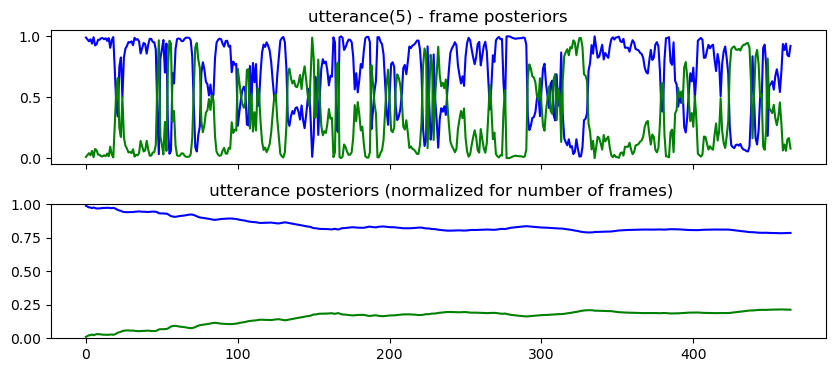

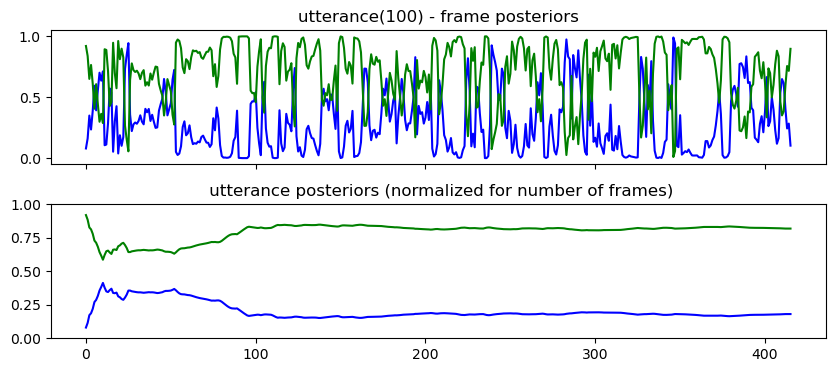

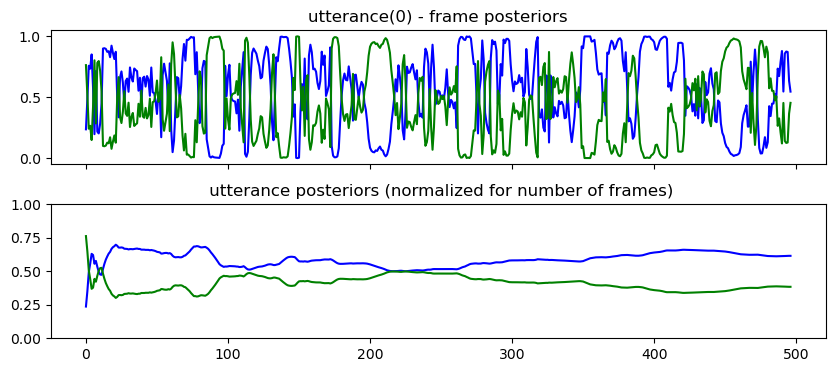

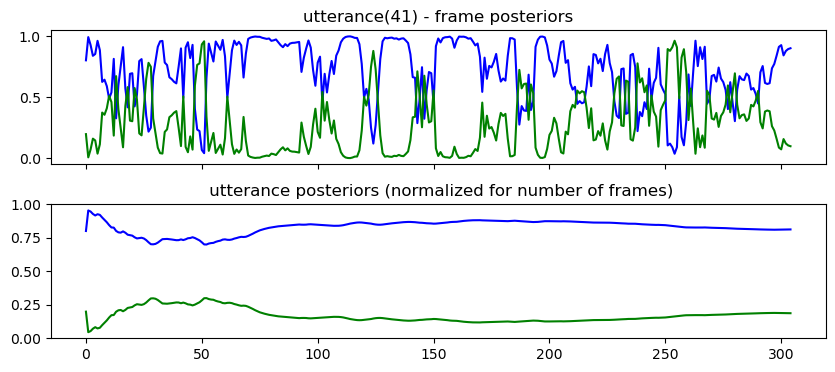

In [13]:
corpus = corpus_test
ftrs = ftrs_test
# examples with 'good recogniton' (5,100), and 'errors' (0: f->m, 41:m->f)
for i in [5,100,0,41]:   
    utt = ftrs[i]
    pred_class, utt_posteriors, utt_likelihood,frame_posteriors = utterance_classifier(utt,clf_GMM,floor=0.001)
    utt_postnorm = frame_normalize(utt_posteriors)
    f,ax = plt.subplots(2,figsize=(10,4),sharex=True,gridspec_kw=dict(hspace=.3))
    ax[0].plot(np.exp(frame_posteriors))
    ax[0].set_title("utterance(%d) - frame posteriors"%i)
    ax[1].plot(np.exp(utt_postnorm))
    ax[1].set_title(" utterance posteriors (normalized for number of frames)")
    ax[1].set_ylim([0.,1.])

Warning(load): could not load the audio resource


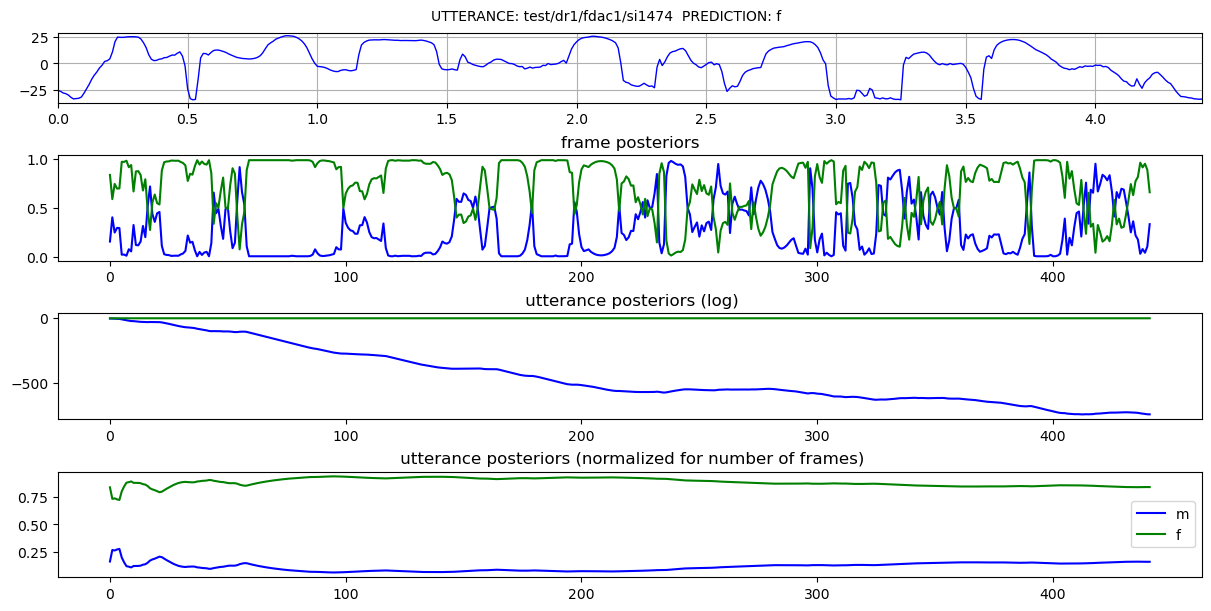

In [14]:
# [53,54,101,140...]
wavroot = "https://homes.esat.kuleuven.be/~spchlab/data/timit/audio/"
corpus = corpus_test
ftrs = ftrs_test
for i in [1]:
    utt = ftrs[i]
    pred_class, utt_posteriors, utt_likelihood,frame_posteriors = utterance_classifier(utt,clf_GMM,floor=0.01)
    fig = Spd.SpchFig(row_heights=[2,3,3,3])
    fig.suptitle("UTTERANCE: %s  PREDICTION: %s" % (corpus.iloc[i]['filename'], pred_class) )
    wavname = wavroot + corpus.iloc[i]['filename'] + ".wav"
    try:
        wavdata, sr = Spch.audio.load(wavname)
        fig.add_line_plot(y=wavdata,iax=0,dx=1./sr)
        display(Audio(data=wavdata,rate=sr))
    except:
    #    pass
        fig.add_line_plot(utt[:,0],iax=0,dx=0.01)
    utt_postnorm = frame_normalize(utt_posteriors)
    #fig.add_line_plot(y=np.exp(frame_posteriors.T),iax=1,dx=0.01,ylabel="Frame Posteriors")
    ax = fig.get_axes()
    ax[1].plot(np.exp(frame_posteriors))
    ax[1].set_title("frame posteriors")
    ax[2].plot(utt_posteriors)
    ax[2].set_title(" utterance posteriors (log)")
    ax[3].plot(np.exp(utt_postnorm))
    ax[3].set_title(" utterance posteriors (normalized for number of frames)")


    #fig.add_line_plot(y=utt_posteriors.T,iax=2,dx=0.01,ylabel="Utt Posteriors (log)")
    #fig.add_line_plot(y=np.exp(utt_postnorm.T),iax=3,dx=0.01,ylabel="Norm Utt Posteriors")
    #ax[1].plot(frame_posteriors)
    #ax[2].plot(utt_posteriors)
    fig.axes[3].legend(clf_GMM.classes)
    #ax[1].plot(np.exp(frame_posteriors))
    #ax[2].plot(np.exp(utt_posteriors))
    display(fig)